# Minimum inter-class distances for different norms and different datasets

In [ ]:
import os
os.chdir("../")
import sys
import json
import math
import numpy as np
import pickle
from PIL import Image
from sklearn import metrics
from sklearn.metrics import pairwise_distances as dist
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper')

import provable_robustness_max_linear_regions.data as dt
from utils import NumpyEncoder, normalize_per_feature_0_1, har, tinyimagenet

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate distances:
Estimated runtime (if no file with data is present): 3 days

Note: The dataset HAR is not included in this repository because of storage issues. You can download the dataset from https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones. After downloading, create a folder 'har' in the root folder of the repository and extract the dataset into the folder.

Note: The dataset TINY-IMAGENET-200 is not included in this repository because of storage issues. You can download the dataset from https://tiny-imagenet.herokuapp.com/. After downloading, create a folder 'tiny-imagenet-200' in the root folder of the repository and extract the dataset into the folder.

Without downloading the two datasets, the following code will not be executable.

In [3]:
def load_from_json(file_name):

    if not os.path.exists("res/" + file_name + ".json"):
        return None
    else:
        with open("res/" + file_name + ".json", 'r') as fp:
            return json.load(fp)
        
def save_to_json(dictionary, file_name):
        
    if not os.path.exists("res"):
        os.makedirs("res")

    with open("res/" + file_name + ".json", 'w') as fp:
        json.dump(dictionary, fp, cls = NumpyEncoder)

In [4]:
dataset_to_n_points = {"mnist": 10000, "fmnist": 10000, "cifar10": 10000, "gts": 10000, "tinyimagenet": 98179, "har": 2947}

minimum_distances = dict()

for dataset in ["mnist", "fmnist", "gts", "har", "tinyimagenet", "cifar10"]:
    
    minimum_distances[dataset] = load_from_json("min_distances_dataset={}_n_points={}".format(dataset, dataset_to_n_points[dataset]))

    if not minimum_distances[dataset]:
        
        if dataset in ["mnist", "fmnist"]:
            
            _, x_test, _, y_test = dt.get_dataset(dataset)
            sample_inputs = x_test[:dataset_to_n_points[dataset]]
            sample_labels = y_test[:dataset_to_n_points[dataset]]
            
            sample_inputs = sample_inputs.reshape(sample_inputs.shape[0], 784)
            
        elif dataset in ["gts", "cifar10"]:
        
            _, x_test, _, y_test = dt.get_dataset(dataset)
            sample_inputs = x_test[:dataset_to_n_points[dataset]]
            sample_labels = y_test[:dataset_to_n_points[dataset]]
            
            sample_inputs = sample_inputs.reshape(sample_inputs.shape[0], 3072)
            
        elif dataset == "har":
        
            _, _, x_test, y_test, _ = har()
            sample_inputs = x_test[:dataset_to_n_points[dataset]]
            sample_labels = y_test[:dataset_to_n_points[dataset]]
        
        elif dataset == "tinyimagenet":

            x_train, y_train = tinyimagenet()
            sample_inputs = x_train[:dataset_to_n_points[dataset]]
            sample_labels = y_train[:dataset_to_n_points[dataset]]
            
            sample_inputs = sample_inputs.reshape(sample_inputs.shape[0], 12288)

        

        minimum_distances[dataset] = {"inner": {"inf": [], "2": [], "1": []}, "outer": {"inf": [], "2": [], "1": []}}
        scipy_norm_to_key = {"chebyshev": "inf", "l2": "2", "l1": "1"}

        for norm in ['chebyshev', 'l2', 'l1']:

            pairwise_distances = dist(sample_inputs, sample_inputs, norm)
            np.fill_diagonal(pairwise_distances, np.inf)
            
            for i, sample_input in enumerate(sample_inputs):
                row = pairwise_distances[i]
                label = sample_labels[i].argmax()
                inner_class_row = [x if sample_labels[j].argmax() == label else np.inf for j, x in enumerate(row)]
                minimum_distances[dataset]["inner"][scipy_norm_to_key[norm]].append(np.min(inner_class_row))

            minimum_distances[dataset]["inner"][scipy_norm_to_key[norm]] = np.sort(minimum_distances[dataset]["inner"][scipy_norm_to_key[norm]])
            
            for i, sample_input in enumerate(sample_inputs):
                row = pairwise_distances[i]
                label = sample_labels[i].argmax()
                inner_class_row = [x if sample_labels[j].argmax() != label else np.inf for j, x in enumerate(row)]
                minimum_distances[dataset]["outer"][scipy_norm_to_key[norm]].append(np.min(inner_class_row))

            minimum_distances[dataset]["outer"][scipy_norm_to_key[norm]] = np.sort(minimum_distances[dataset]["outer"][scipy_norm_to_key[norm]])

        save_to_json(minimum_distances[dataset], "min_distances_dataset={}_n_points={}".format(dataset, dataset_to_n_points[dataset]))

## Plot:

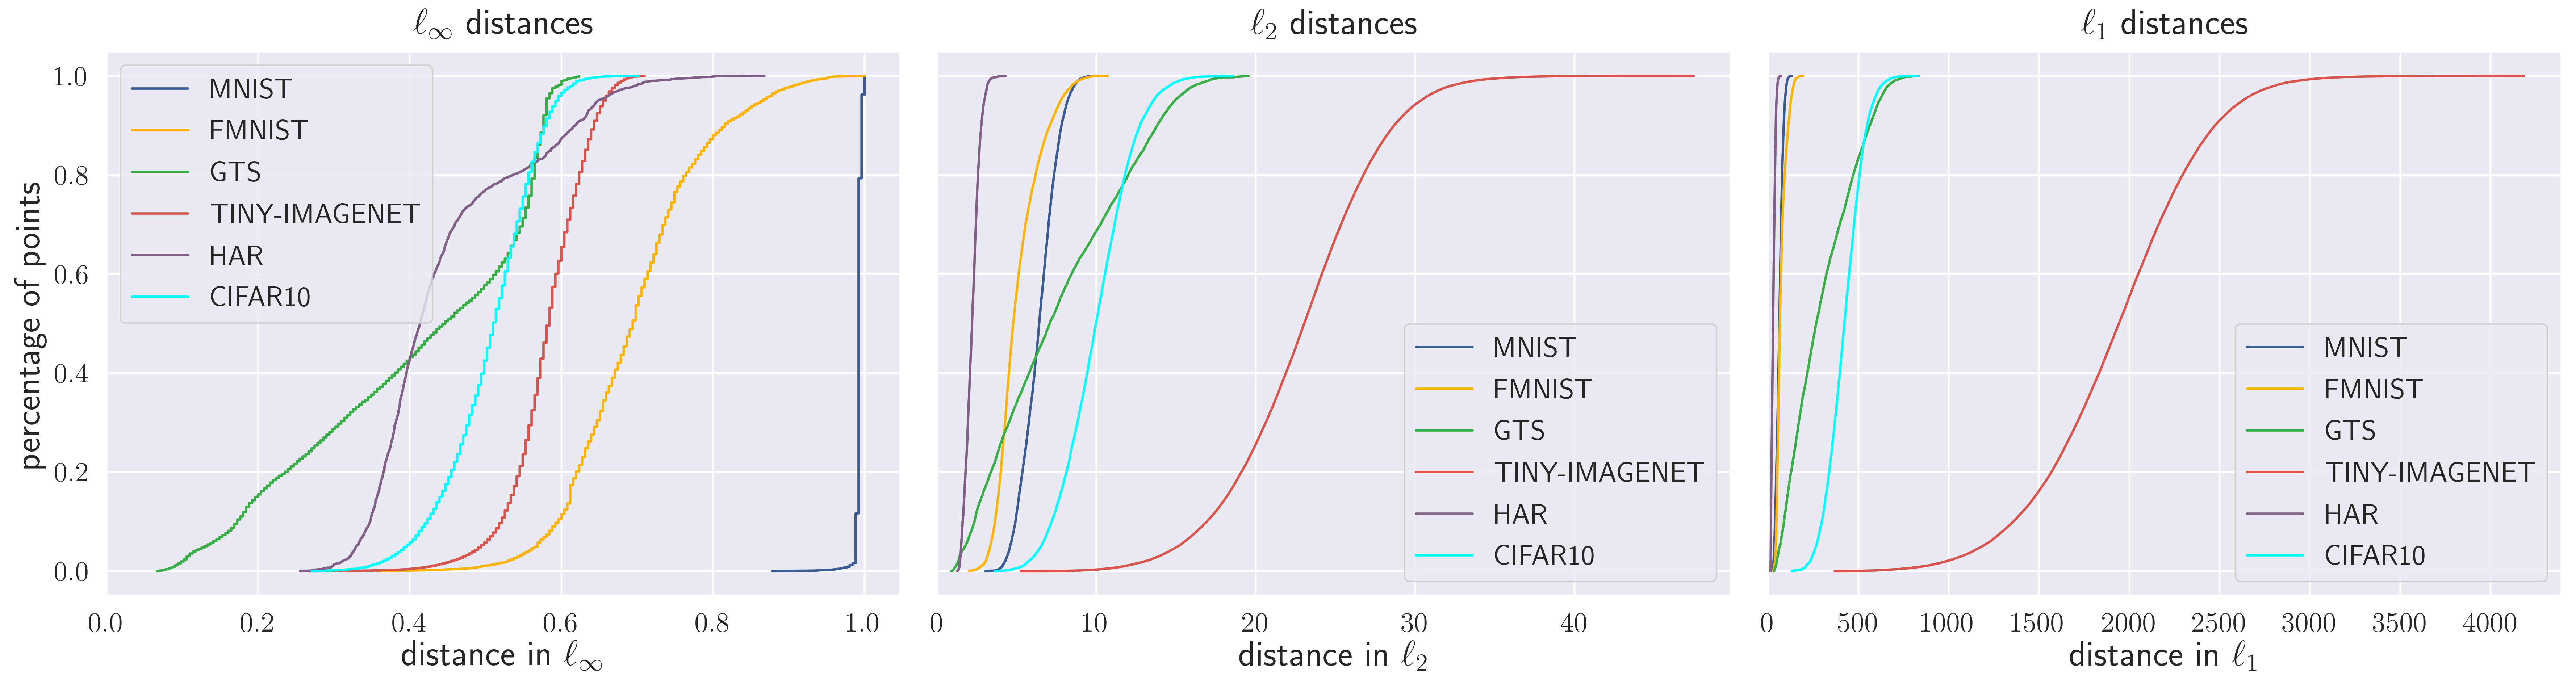

In [5]:
# name to save the plot
save_name = "fig_distances_all_datasets_all_norms"

# number of model types and parameter combinations
n_cols = 3
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize = (6 * n_cols, 5 * n_rows), sharey = True, dpi=400)

norm_to_latex = {"inf":"\ell_\infty", "2":"\ell_2", "1": "\ell_1"}
color_map = {"mnist": colors["blue"], "cifar10": colors["cyan"], "fmnist": colors["yellow"], "gts": colors["green"], "tinyimagenet": colors["red"], "har": colors["purple"]}
label_map = {"mnist": "MNIST", "cifar10": "CIFAR10", "fmnist": "FMNIST", "gts": "GTS", "tinyimagenet": "TINY-IMAGENET", "har": "HAR"}

for dataset in ["mnist", "fmnist", "gts", "tinyimagenet", "har", "cifar10"]:

    for i, norm in enumerate(["inf", "2", "1"]):

        # filters duplicates with different class
        minimum_distances[dataset]["outer"][norm] = [value for value in minimum_distances[dataset]["outer"][norm] if value >= 0.0001]

        ax[i].plot(minimum_distances[dataset]["outer"][norm], np.linspace(0.0, 1.0, len(minimum_distances[dataset]["outer"][norm])), c=color_map[dataset], label = label_map[dataset])
        ax[i].set_xlabel("distance in ${}$".format(norm_to_latex[norm]))
        ax[i].legend()

ax[0].set_ylabel("percentage of points")
ax[0].set_title("$\ell_\infty$ distances")
ax[1].set_title("$\ell_2$ distances")
ax[2].set_title("$\ell_1$ distances")

ax[0].set_xlim(left = 0.0)
ax[1].set_xlim(left = 0.0)
ax[2].set_xlim(left = 0.0)

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))